In [213]:
import csv
from collections import defaultdict
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_rand_score

import sys
#base_dir = os.environ['AWEB_DIR']
sys.path.append("../../")
import config
from sklearn.cluster import KMeans

In [214]:
def convert_keys_to_int(d):
    new_dict = {}
    for k, v in d.items():
        new_key = int(k) if k.isdigit() else k
        if isinstance(v, dict):
            new_dict[new_key] = convert_keys_to_int(v)
        else:
            new_dict[new_key] = v
    return new_dict

In [215]:
result_dir = config.OUTPUT_DIR
embeddings_dir = config.EMBEDDING_DIR
data_dir = config.DATA_DIR
print(result_dir)
with open(data_dir+'attack_weak_range.json') as fp:
    attack_weak_range = json.load(fp)
with open(data_dir+"bron_attack_cwe.json") as fp:
    bron_attack_cwe=json.load(fp)
with open(data_dir+"bron_cwe_attack.json") as fp:
    bron_cwe_attack=json.load(fp)
with open(data_dir+"rand_hit_k_1000.json") as fp:
    rand_hit_k=json.load(fp)   
with open(data_dir+"rand_hit_k_avg_1000.json") as fp:
    rand_hit_k_avg=json.load(fp)

bron_attack_cwe = convert_keys_to_int(bron_attack_cwe)
bron_cwe_attack = convert_keys_to_int(bron_cwe_attack)
rand_hit_k = convert_keys_to_int(rand_hit_k)
rand_hit_k_avg = convert_keys_to_int(rand_hit_k_avg)
attack_size=attack_weak_range['attack'][1]
weakness_size=attack_weak_range['cwe'][1]-attack_size

/home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/


In [216]:
mx_w = 0
for a in bron_attack_cwe:
    mx_w = max(mx_w,len(bron_attack_cwe[a]))
print("Max # weak with an Attack:", mx_w)
mx_a = 0
for w in bron_cwe_attack:
    mx_a = max(mx_a,len(bron_cwe_attack[w]))
print("Max # attack with a weakness:", mx_a)

Max # weak with an Attack: 71
Max # attack with a weakness: 22


In [217]:
result_dir

'/home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/'

In [218]:
def get_kmeans(embeddings):
    # List of k values
    k_values = [5, 10, 15, 20, 25]
    # Dictionary to store cluster labels for each k
    cluster_results = {}
    
    # Perform K-means clustering for each k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        cluster_results[k] = cluster_labels
    
    # # Print the dictionary keys to verify the results
    # print(cluster_results.keys())
    
    # # Optionally, print the first few labels for each k
    # for k, labels in cluster_results.items():
    #     print(f"Cluster labels for k={k}: {labels[:10]}")
    return cluster_results

In [220]:
from collections import defaultdict
sample = 10
dual = "dual3"
loss_func = "triplet"
plot_dir = result_dir+"plots/sample_{}/{}/".format(sample,loss_func)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(plot_dir+"src/"):
    os.makedirs(plot_dir+"src/")
models = ["pt_gpt2-xl", "gpt2-xl"]
gnn_models = ["GCN","GAT"]
features = ["text", "text_hop", "node2vec", "deepwalk"]
# gnn_models = ["GAN_embeddings","GCN_embeddings"]
graph_embeddings = {}
graph_embeddings["node2vec"]=np.load(embeddings_dir+"node2vec.npy")
graph_embeddings["deepwalk"]=np.load(embeddings_dir+"deepwalk.npy")
gnn_embeddings = defaultdict(list)
text_hop_embeddings = defaultdict(list)
text_hop_embeddings["bert"].append(np.load(embeddings_dir+"pt_bert/text_embeddings.npy"))


for model in models:
    text_emb_dir = embeddings_dir+model+"/"
    gcl_data_dir = result_dir+"gcl_data/"+model+"/"
    text_hop_embeddings["text"].append(np.load(text_emb_dir+"text_embeddings.npy"))
    text_hop_embeddings["hop_text"].append(np.load(text_emb_dir+"text_hop_embeddings.npy"))
    
    if not os.path.exists(gcl_data_dir+"sample_{}/rand_index/".format(sample)):
        os.makedirs(gcl_data_dir+"sample_{}/rand_index/".format(sample))
    gnn_hop = []
    gnn_node2vec = []
    gnn_deepwalk = []
    gnn_text = []
    for j in range(len(gnn_models)):

        gnn_embeddings2=np.load(gcl_data_dir+"sample_{}/{}/{}/text_hop_{}_gm_1.0.npy".format(sample,gnn_models[j],loss_func, dual))
        gnn_hop.append(gnn_embeddings2)
        gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/text_node2vec_{}_gm_1.0.npy".format(sample,gnn_models[j],loss_func, dual))
        gnn_node2vec.append(gnn_embeddings3)
        gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/text_deepwalk_{}_gm_1.0.npy".format(sample,gnn_models[j],loss_func,dual))
        gnn_deepwalk.append(gnn_embeddings3)


        # gnn_embeddings2=np.load(gcl_data_dir+"sample_{}/{}/{}/text_hop_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
        # gnn_hop.append(gnn_embeddings2)
        # gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/node2vec_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
        # gnn_node2vec.append(gnn_embeddings3)
        # gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/deepwalk_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
        # gnn_deepwalk.append(gnn_embeddings3)
        # if(dual==""):
        #     gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/text_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
        #     gnn_text.append(gnn_embeddings3)


    
        # gnn_embeddings2.append(np.load(dir_name+"{}/sample_{}/hop_gm_1.0.npy".format(gnn_models[j],sample)))
        # gnn_emb_matrix2.append(cosine_similarity(gnn_embeddings2[-1]))
        # gnn_embeddings2.append(np.load(dir_name+"{}/sample_{}/node2vec_gm_1.0.npy".format(gnn_models[j],sample)))
        # gnn_emb_matrix2.append(cosine_similarity(gnn_embeddings2[-1]))
    gnn_embeddings["hop_text"].append(gnn_hop)
    gnn_embeddings["node2vec"].append(gnn_node2vec)
    gnn_embeddings["deepwalk"].append(gnn_deepwalk)
    if(dual==""):
        gnn_embeddings["text"].append(gnn_text)



In [221]:
def get_rand_index_text(base_kmeans, predict_kmeans):
    rand_scores = []
    for k in k_values:
        rand_scores.append(adjusted_rand_score(base_kmeans[k], predict_kmeans[k]))
    
    return rand_scores

In [222]:
def generate_rand_index(base, ctype):
    text_graph_src = {}
    text_gnn_src_list = []
    text_hop_gnn_src_list = []
    node2vec_gnn_src_list = []
    deepwalk_gnn_src_list = []
    text_src = []
    text_hop_src = []
    node2vec_src=[]
    deepwalk_src=[]
    if(ctype=="attack_graph" or ctype=="attack_text"):
        base_kmeans = get_kmeans(base[:attack_size])
    elif(ctype=="weak_graph" or ctype=="weak_text"):
        base_kmeans = get_kmeans(base[attack_size:])
    # get_kmeans(gnn_deepwalk_e[-1])
    for i,model in enumerate(models):
        print("Model: ", model)
        text_gnn_src = []
        hop_gnn_src = []
        node2vec_gnn_src = []
        deepwalk_gnn_src = []
        for j in range(len(gnn_models)):
            print("\tGNN: ", gnn_models[j])
            # gnn_hop_kmeans.append(gnn_hop)
            # gnn_node2vec_kmeans.append(gnn_node2vec)
            # gnn_deepwalk_kmeans.append(gnn_deepwalk)
            if(ctype=="attack_graph" or ctype=="attack_text"):
                # gnn_text_kmeans = get_kmeans(gnn_embeddings["text"][i][j][:attack_size])
                gnn_hop_kmeans= get_kmeans(gnn_embeddings["hop_text"][i][j][:attack_size])
                gnn_node2vec_kmeans= get_kmeans(gnn_embeddings["node2vec"][i][j][:attack_size])
                gnn_deepwalk_kmeans= get_kmeans(gnn_embeddings["deepwalk"][i][j][:attack_size])
            elif(ctype=="weak_graph" or ctype=="weak_text"):
                # gnn_text_kmeans = get_kmeans(gnn_embeddings["text"][i][j][attack_size:])
                gnn_hop_kmeans= get_kmeans(gnn_embeddings["hop_text"][i][j][attack_size:])
                gnn_node2vec_kmeans= get_kmeans(gnn_embeddings["node2vec"][i][j][attack_size:])
                gnn_deepwalk_kmeans= get_kmeans(gnn_embeddings["deepwalk"][i][j][attack_size:])
                
            # spearman_corr = get_rand_index_text(base_kmeans,gnn_text_kmeans)
            # text_gnn_src.append(spearman_corr)
            spearman_corr = get_rand_index_text(base_kmeans,gnn_hop_kmeans)
            hop_gnn_src.append(spearman_corr)
            spearman_corr = get_rand_index_text(base_kmeans,gnn_node2vec_kmeans)
            node2vec_gnn_src.append(spearman_corr)
            spearman_corr = get_rand_index_text(base_kmeans,gnn_deepwalk_kmeans)
            deepwalk_gnn_src.append(spearman_corr)
        # text_gnn_src_list.append(text_gnn_src)
        text_hop_gnn_src_list.append(hop_gnn_src)
        node2vec_gnn_src_list.append(node2vec_gnn_src)
        deepwalk_gnn_src_list.append(deepwalk_gnn_src)
        if(ctype=="attack_graph" or ctype=="attack_text"):
            text_kmeans = get_kmeans(text_hop_embeddings["text"][i][:attack_size])
            hop_kmeans= get_kmeans(text_hop_embeddings["hop_text"][i][:attack_size])

        elif(ctype=="weak_graph" or ctype=="weak_text"):
            text_kmeans = get_kmeans(text_hop_embeddings["text"][i][attack_size:])
            hop_kmeans= get_kmeans(text_hop_embeddings["hop_text"][i][attack_size:])

        spearman_corr = get_rand_index_text(base_kmeans,text_kmeans)
        text_src.append(spearman_corr)
        spearman_corr = get_rand_index_text(base_kmeans,hop_kmeans)
        text_hop_src.append(spearman_corr)
    if(ctype=="attack_graph" or ctype=="attack_text"):
        node2vec_kmeans = get_kmeans(graph_embeddings["node2vec"][:attack_size])
        deepwalk_kmeans= get_kmeans(graph_embeddings["deepwalk"][:attack_size])

    elif(ctype=="weak_graph" or ctype=="weak_text"):
        node2vec_kmeans = get_kmeans(graph_embeddings["node2vec"][attack_size:])
        deepwalk_kmeans= get_kmeans(graph_embeddings["deepwalk"][attack_size:])

    spearman_corr = get_rand_index_text(base_kmeans,node2vec_kmeans)
    node2vec_src=(spearman_corr)
    spearman_corr = get_rand_index_text(base_kmeans,deepwalk_kmeans)
    deepwalk_src=(spearman_corr)
    # text_graph_src["text_gnn"]=text_gnn_src_list
    text_graph_src["text_hop_gnn"]=text_hop_gnn_src_list
    text_graph_src["node2vec_gnn"]=node2vec_gnn_src_list
    text_graph_src["deepwalk_gnn"]=deepwalk_gnn_src_list
    text_graph_src["text"]=text_src
    text_graph_src["text_hop"]=text_hop_src
    text_graph_src["node2vec"]=node2vec_src
    text_graph_src["deepwalk"]=deepwalk_src
    return text_graph_src

In [223]:
text_rand_index_list = generate_rand_index(text_hop_embeddings["bert"][0], "attack_text")

/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Model:  pt_gpt2-xl
	GNN:  GCN


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

	GNN:  GAT


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Model:  gpt2-xl
	GNN:  GCN


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

	GNN:  GAT


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

In [224]:
text_rand_index_list_weak = generate_rand_index(text_hop_embeddings["bert"][0], "weak_text")

/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Model:  pt_gpt2-xl
	GNN:  GCN


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

	GNN:  GAT


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Model:  gpt2-xl
	GNN:  GCN


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

	GNN:  GAT


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

In [225]:
graph_rand_index_list = generate_rand_index(graph_embeddings["deepwalk"], "attack_graph")

/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Model:  pt_gpt2-xl
	GNN:  GCN


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

	GNN:  GAT


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Model:  gpt2-xl
	GNN:  GCN


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

	GNN:  GAT


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

In [226]:
graph_rand_index_list_weak = generate_rand_index(graph_embeddings["deepwalk"], "weak_graph")

/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Model:  pt_gpt2-xl
	GNN:  GCN


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

	GNN:  GAT


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Model:  gpt2-xl
	GNN:  GCN


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

	GNN:  GAT


/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/afarhan/anaconda3/envs/gpt/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

In [228]:
def plot_SRC_K(graph_src, _type):
    dual = "dual3"
    # Initialize a dictionary to store average hit@k for each k
    markers = ['o', 's', '+', 'v', '<', '>']
    colors = list(mcolors.TABLEAU_COLORS)
    colors.pop(3)
    plt.figure(figsize=(5, 8))
    ks = list(range(5, 30, 5))
    # if(_type!="text"):
    hits2 = graph_src["node2vec"]
    hits3 = graph_src["deepwalk"]
            
    plt.plot(ks, hits2, label="node2vec", marker='x', color = 'tab:olive')
    plt.plot(ks, hits3, label="deeplwalk", marker='x', color = 'tab:cyan')


    # plt.plot(ks, hits1, label="Random Pick", marker='x', color = 'tab:red')
    all_hits = []
    for i in range(0,len(models),1):
        # Define the cosine similarity matrices
        model = models[i]
        # if(_type=="text"):
        #     if(i==0):
        #         mrk='x'
        #     else:
        #         mrk='P'
        #     hits2 = graph_src["node2vec"][i]
        #     hits3 = graph_src["deepwalk"][i]
                    
        #     plt.plot(ks, hits2, label=model+" node2vec", marker=mrk, color = 'tab:olive')
        #     plt.plot(ks, hits3, label=model+" deeplwalk", marker=mrk, color = 'tab:cyan')
        for j in range(len(gnn_models)):
            hits4 = graph_src["text_hop_gnn"][i][j]
            
            hits5 = graph_src["node2vec_gnn"][i][j]
           
            hits6 =  graph_src["deepwalk_gnn"][i][j]
            if(dual==""):
                 
                hits9 = graph_src["text_gnn"][i][j]
            plt.plot(ks, hits4, label=models[i]+" "+gnn_models[j] +" hop", marker="*", color = colors[j+i*5])
            plt.plot(ks, hits5, label=models[i]+" "+gnn_models[j]+ " node2vec", marker="s", color = colors[j+i*5])
            plt.plot(ks, hits6, label=models[i]+" "+gnn_models[j]+ " deepwalk", marker="p", color = colors[j+i*5])
            if(dual==""):
                plt.plot(ks, hits9, label=models[i]+" "+gnn_models[j]+ " text", marker="|", color = colors[j+i*5])
        
        hits7 = graph_src["text"][i]
        hits8 = graph_src["text_hop"][i]
        
        if(i==0):
            cl1 = "tab:green"
        else:
            cl1 = "tab:purple"
        plt.plot(ks, hits7, label=models[i]+" Text emb", marker='.', color = cl1)
        plt.plot(ks, hits8, label=models[i]+" Hop emb", marker='v', color = cl1)



    plt.xlabel('K')
    plt.ylabel('Average rand index')
    plt.xticks(ks)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    #plt.title('GNN Semi Supervised - Text - Hop Embeddings')
    isAverage=True
    
    if(_type.split("_")[0]=="attack"):
        if(isAverage):
            plt.title('GNN-{} Avg rand-index Attack to '.format(dual,_type))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "avg_{}_rand-index_gnn_{}_sample_{}.png".format(_type,dual,sample)
        else:
            plt.title('GNN-{}rand-index Attack to {}'.format(dual,_type))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "{}_rand-index_gnn_{}_sample_{}.png".format(_type,dual,sample)
    elif(_type.split("_")[0]=="weak"):
        if(isAverage):
            plt.title('GNN-{} Avg rand-index CWE to {}'.format(dual,_type))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "avg_{}_rand-index_gnn_{}_sample_{}.png".format(_type,dual,sample)
        else:
            plt.title('GNN-{} rand-index CWE to {}'.format(dual,_type))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "{}_rand-index_gnn_{}_sample_{}.png".format(_type,dual,sample)
    elif(_type=="text"):
        if(isAverage):
            plt.title('GNN-{} Avg rand-index Bert Text'.format(dual))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "avg_{}_rand-index_gnn_{}_sample_{}.png".format(_type,dual,sample)
        else:
            plt.title('GNN-{} rand-index Bert Text'.format(dual))
            #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
            title = "{}_rand-index_gnn_{}_sample_{}.png".format(_type,dual,sample)

    
    # if(_type=="attack_graph"):
        
    #     plt.title('Graph-GNN-{} rand index@k'.format(dual))
    #     #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
    #     title = "Attack_rand_index@k_gnn_{}_sample_{}.png".format(dual,sample)
    # else:
    #     plt.title('Text GNN-{} SRC@k'.format(dual))
    #     #title = "avg_bron_hit@k_gnn_sample_{}_th_{}_{}.png".format(sample, threshold[0], threshold[1])
    #     title = "Text_rand_index@k_gnn_{}_sample_{}.png".format(dual,sample)
    # else:
    #     if(isAverage):
    #         plt.title('Bron-GNN-dual Avg Hit@k Weakness to Attack')
    #         title = "avg_bron_hit@k_gnn_dual_sample_{}_weak_attack.png".format(sample)
    #     else:
    #         plt.title('Bron-GNN Hit@k Weakness to Attack')
    #         title = "bron_hit@k_gnn_sample_{}_weak_attack.png".format(sample)
            
    plt.savefig(plot_dir+title, dpi=300, bbox_inches='tight')
    plt.show()

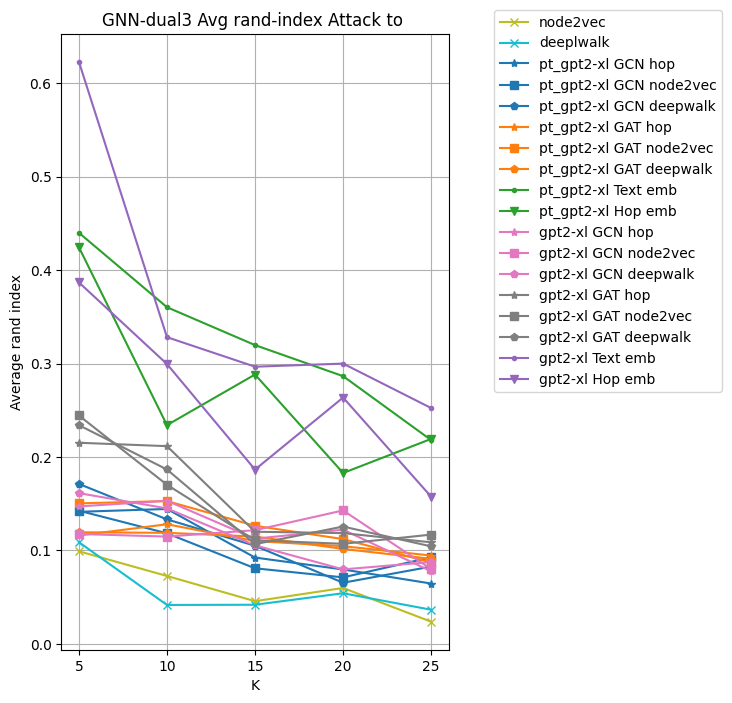

In [234]:
plot_SRC_K(text_rand_index_list, "attack_text")

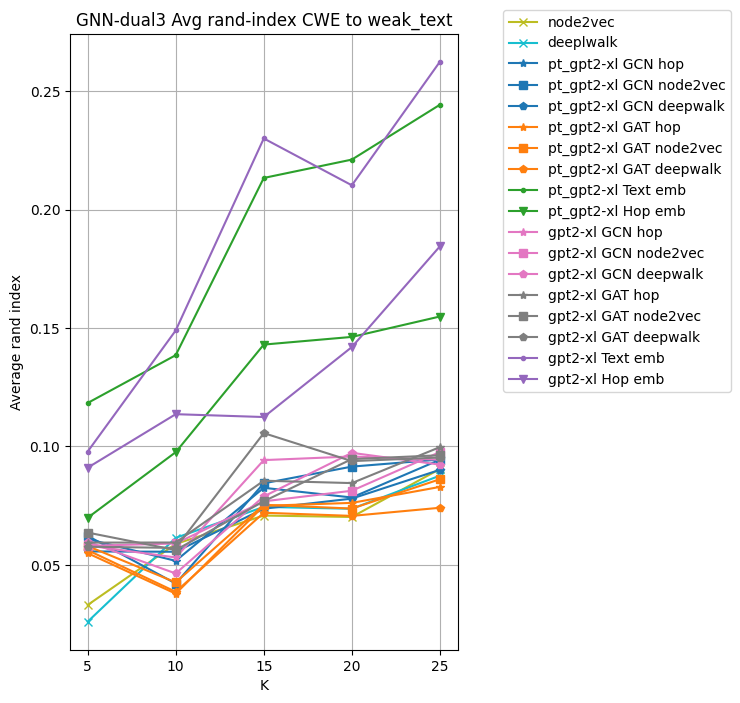

In [231]:
plot_SRC_K(text_rand_index_list_weak, "weak_text")

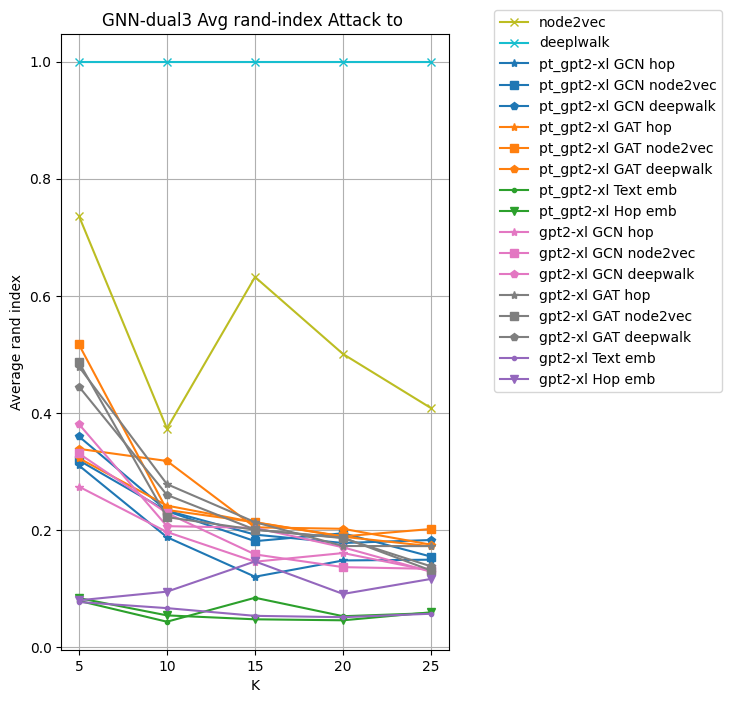

In [232]:
plot_SRC_K(graph_rand_index_list, "attack_graph")

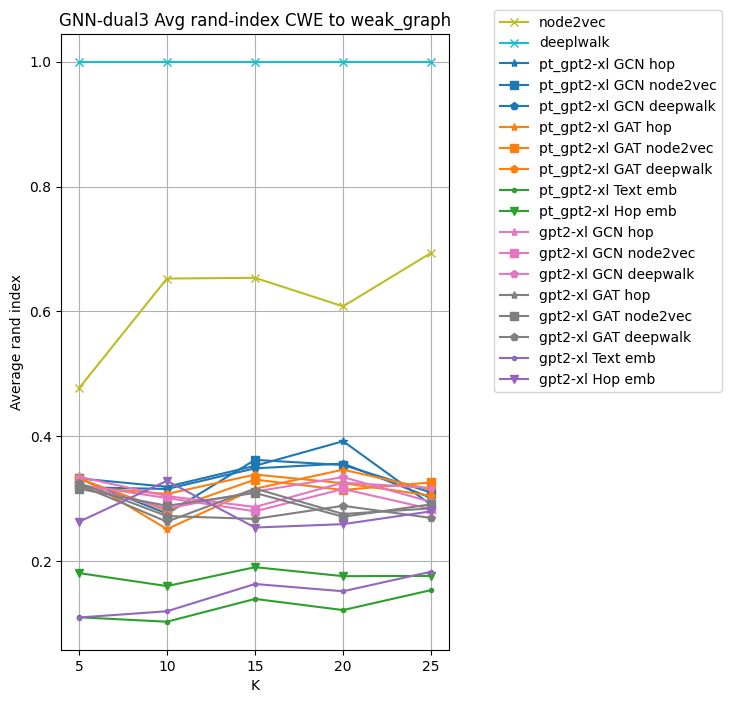

In [233]:
plot_SRC_K(graph_rand_index_list_weak, "weak_graph")